In [11]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

import warnings
warnings.filterwarnings("ignore")
import numpy.random as rng
import numpy.linalg as lin
import control as cm
from helperFunctions import *
setPlotStyle()


 ## Connecting the dots



 Time to make the full picture: state feedback control with state estimation! Some important things to note:

 - Since the state feedback is based on the state estimation, we want the error to go to zero faster than the controller works. If the controller is faster than the observer you're just doing random stuff basically until the estimate converges. Rule of thumb: the observer should be 4 to 10 times faster (larger magnitude poles) than the controller.

 - Making the observer extremely fast works well in theory, but as soon as your output is noisy, the fast observer will amplify this noise enourmously and your estimate will be terrible.

 - In the example below I'll make an LQR observer, but since the observer is a regulator type controller, no feedforward gain is needed.

 - Strictly speaking you can classify this as output feedback



 Please also take a look at the code for how to use the control toolbox more effectively.

<IPython.core.display.Javascript object>

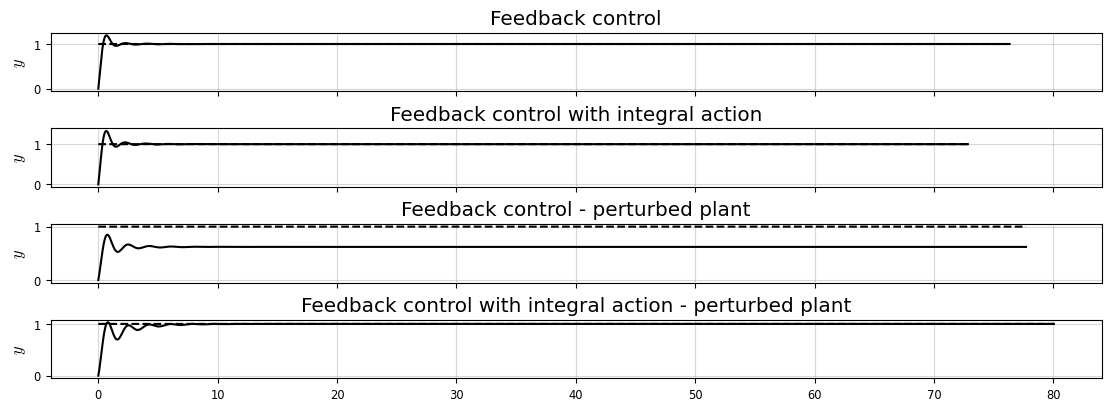

In [22]:
s = cm.tf('s')
P_all = cm.rss(5, inputs='u_tot', outputs='y', name='P', strictly_proper=True)
nx_all = P_all.A.shape[0]
x0_all = rng.randn(nx_all,1)

## Integral action (negative for coding reasons (flipped sumblock later))
ki_all = -1.

## LQR state 
assert isControlable(P_all.A, P_all.B)==True, "System is uncontrollable D:"

Qx_K, Qu_K = np.eye(nx_all)*1e0, np.eye(1)*1e0
K_all, _, _ = cm.lqr(P_all.A, P_all.B, Qx_K, Qu_K) 
kf_all = (-1/(P_all.C@lin.inv(P_all.A - P_all.B@K_all)@P_all.B))[0,0]

## Observer
assert isObservable(P_all.A, P_all.C)==True, "System is unobservable D:"

Qx_obs, Qu_obs = np.eye(nx_all)*1e3, np.eye(1)*1e0 # Note the much higher penalty on state esimation error
L_all, _, _ = cm.lqr(P_all.A.transpose(), P_all.C.transpose(), Qx_obs, Qu_obs)
L_all = L_all.transpose()
obs_all = cm.ss(P_all.A - L_all @ P_all.C,
                np.hstack((P_all.B, L_all)),
                np.eye(nx_all),
                np.zeros([nx_all,2]),
                inputs = ["u_tot", "y"], 
                # outputs = ['x_est'], # it doesn't understand ):
                name="Observer")

## Also create perturbed system
ran = np.abs(1. + rng.randn(2) * .1)
poles_all_pert = [(ran[0] * pole.real + ran[1] * pole.imag*1j).astype(np.complex64) 
                  for pole in P_all.poles()]

P_all_pert = cm.ss(cm.zpk(zeros=P_all.zeros().astype(np.complex64), 
                        poles=poles_all_pert, 
                        gain=1, dt=0), 
                    inputs='u_tot', outputs='y', name='P')
P_all_pert.C *= rng.randn()*.2 + 1.

## Build blocks and subsystems
u_sumblk = cm.summing_junction(
    inputs = ["u_ctrl", "u_rff", "u_int"],
    output = "u_tot",
    name = "u_sumblk"
)
r_sumblk = cm.summing_junction(
    inputs = ["y", "ref"],
    output = ["ref_err"],
    name = "r_sumblk"
)
integral_action = cm.ss(-ki_all/s, 
                        inputs = "ref_err",
                        output = "u_int",
                        name = "integral_action")
Kctrl = cm.ss([[0]], np.zeros_like(K_all), [[0]], -K_all, 
                # inputs = "x_est", # it doesn't understand ):
                output = "u_ctrl",
                name = "Kctrl")
FBctrl = cm.series(obs_all, Kctrl,
                    inputs = ['u_tot', 'y'],
                    outputs = "u_ctrl",
                    name = "FBctrl")
rFFgain = cm.ss([[0]], [[0]], [[0]], [[kf_all]], 
                inputs = "ref",
                output = "u_rff",
                name = "rFFgain")

## Build systems: with and without integral action and for a perturbed system
CL_FBctrl = cm.interconnect(syslist = [P_all, FBctrl, rFFgain, u_sumblk],
                            connections = [
                                ['P', 'u_sumblk.u_tot'],
                                ['FBctrl.y', 'P'],
                                ['FBctrl.u_tot', 'u_sumblk.u_tot'],
                                ['u_sumblk.u_rff', 'rFFgain'],
                                ['u_sumblk.u_ctrl', 'FBctrl']
                                ],
                            inputs = 'ref',
                            outputs = 'y')
CL_FBctrl_int = cm.interconnect(syslist = [P_all, FBctrl, rFFgain, u_sumblk, integral_action, r_sumblk],
                                connections = [
                                    ['P', 'u_sumblk.u_tot'],
                                    ['FBctrl.y', 'P'],
                                    ['FBctrl.u_tot', 'u_sumblk.u_tot'],
                                    ['u_sumblk.u_rff', 'rFFgain'],
                                    ['u_sumblk.u_ctrl', 'FBctrl'],
                                    ['integral_action', 'r_sumblk'],
                                    ['r_sumblk.y', '-P.y'],
                                    ['u_sumblk.u_int', 'integral_action']
                                    ],
                                inputs = 'ref',
                                outputs = 'y')
CL_FBctrl_pert = cm.interconnect(syslist = [P_all_pert, FBctrl, rFFgain, u_sumblk],
                                connections = [
                                    ['P', 'u_sumblk.u_tot'],
                                    ['FBctrl.y', 'P'],
                                    ['FBctrl.u_tot', 'u_sumblk.u_tot'],
                                    ['u_sumblk.u_rff', 'rFFgain'],
                                    ['u_sumblk.u_ctrl', 'FBctrl']
                                    ],
                                inputs = 'ref',
                                outputs = 'y')
CL_FBctrl_int_pert = cm.interconnect(syslist = [P_all_pert, FBctrl, rFFgain, u_sumblk, integral_action, r_sumblk],
                                connections = [
                                    ['P', 'u_sumblk.u_tot'],
                                    ['FBctrl.y', 'P'],
                                    ['FBctrl.u_tot', 'u_sumblk.u_tot'],
                                    ['u_sumblk.u_rff', 'rFFgain'],
                                    ['u_sumblk.u_ctrl', 'FBctrl'],
                                    ['integral_action', 'r_sumblk'],
                                    ['r_sumblk.y', '-P.y'],
                                    ['u_sumblk.u_int', 'integral_action']
                                    ],
                                inputs = 'ref',
                                outputs = 'y')

## Look at step response
fig, ax = plt.subplots(4, 1, sharex=True)
for sys, idx, title in zip([CL_FBctrl, CL_FBctrl_int, CL_FBctrl_pert, CL_FBctrl_int_pert], range(4),
                           ["Feedback control", "Feedback control with integral action",
                            "Feedback control - perturbed plant", "Feedback control with integral action - perturbed plant"]):
    response = cm.step_response(sys)
    ax[idx].plot(response.time, response.inputs, 'k--')
    ax[idx].plot(response.time, response.outputs, 'k')
    ax[idx].set(ylabel="$y$", title=title)

display(fig)


 Run the previous cell a few times... fun fact: there is no generic fix for control problems...